<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Осень 2020</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/t/f50bc21dbe0e42dabe5e32a21f2e5235) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика. 

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


# Первая часть. Исследование.

In [4]:
%%capture
%%bash
pip install catboost

In [52]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, LogisticRegressionCV
from sklearn.preprocessing import *
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from catboost import CatBoostClassifier, Pool, cv as catboost_cv
from sortedcontainers import SortedList
import copy
import collections
from itertools import product,chain
import random
random_state = 42
random.seed(42)
np.random.seed(42)
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [178]:
###helpers functions

def display_classification_report(y_true, y_pred):
    display(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T)

def plot_roc(y_test, preds, ax=None, label='model'):
    with plt.style.context('seaborn-whitegrid'):
        if not ax: fig, ax = plt.subplots(1, 1)
        fpr, tpr, thresholds = roc_curve(y_test, preds)
        ax.plot([0, 1], [0, 1],'r--')
        ax.plot(fpr, tpr, lw=2, label=label)
        ax.legend(loc='lower right')
        ax.set_title(
             'ROC curve\n'
            f""" AP: {average_precision_score(
                y_test, preds, pos_label=1
            ):.2} | """
            f'AUC: {auc(fpr, tpr):.2}')
        ax.set_xlabel('False Positive Rate (FPR)')
        ax.set_ylabel('True Positive Rate (TPR)')
        ax.annotate(f'AUC: {auc(fpr, tpr):.2}', xy=(.43, .025))
        ax.legend()
        ax.grid()
        return ax
    

def plot_pr(y_test, preds, ax=None, label='model'):
    with plt.style.context('seaborn-whitegrid'):
        precision, recall, thresholds = precision_recall_curve(y_test, preds)
        if not ax: fig, ax = plt.subplots()
        ax.plot([0, 1], [1, 0],'r--')    
        ax.plot(recall, precision, lw=2, label=label)
        ax.legend()
        ax.set_title(
            'Precision-recall curve\n'
            f""" AP: {average_precision_score(
                y_test, preds, pos_label=1
            ):.2} | """
            f'AUC: {auc(recall, precision):.2}'
        )
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
        ax.legend()
        ax.grid()
        return ax


#missing value ratio
def missing_values(df):
    df_nulls=pd.concat([df.dtypes, df.isna().sum(), df.isna().sum()/len(df)], axis=1)
    df_nulls.columns = ["type","count","missing_ratio"]
    df_nulls=df_nulls[df_nulls["count"]>0]
    df_nulls.sort_values(by="missing_ratio", ascending=False)
    return df_nulls

#outliers by 3 sigma rule
def outlier(data):
    data_mean, data_std = np.mean(data), np.std(data)
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers = [x for x in data if x < lower or x > upper]
    outliers_removed = [x for x in data if x >= lower and x <= upper]
    return len(outliers)

# full description statistics 
def describe_full(df, target_name=""):
    data_describe = df.describe().T
    df_numeric = df._get_numeric_data()
    if target_name in df.columns:
        corr_with_target=df_numeric.drop(target_name, axis=1).apply(lambda x: x.corr(df_numeric[target_name]))
        data_describe['corr_with_target']=corr_with_target
    dtype_df = df_numeric.dtypes
    data_describe['dtypes'] = dtype_df
    data_null = df_numeric.isnull().sum()/len(df) * 100
    data_describe['Missing count'] = df_numeric.isnull().sum()
    data_describe['Missing %'] = data_null
    Cardinality = df_numeric.apply(pd.Series.nunique)
    data_describe['Cardinality'] = Cardinality
    df_skew = df_numeric.skew(axis=0, skipna=True)
    data_describe['Skew'] = df_skew
    data_describe['outliers']=[outlier(df_numeric[col]) for col in df_numeric.columns]
    data_describe['kurtosis']=df_numeric.kurtosis()
    return data_describe

def display_group_density_plot(df, groupby, on, palette = None, figsize = None, title="", ax=None): 
    """
    Displays a density plot by group, given a continuous variable, and a group to split the data by
    :param df: DataFrame to display data from
    :param groupby: Column name by which plots would be grouped (Categorical, maximum 10 categories)
    :param on: Column name of the different density plots
    :param palette: Color palette to use for drawing
    :param figsize: Figure size
    :return: matplotlib.axes._subplots.AxesSubplot object
    """
    if palette is None:
      palette = sns.color_palette('Set2')
    if figsize is None:
      figsize = (10, 5)
    if not isinstance(df, pd.core.frame.DataFrame):
        raise ValueError('df must be a pandas DataFrame')

    if not groupby:
        raise ValueError('groupby parameter must be provided')

    elif not groupby in df.keys():
        raise ValueError(groupby + ' column does not exist in the given DataFrame')

    if not on:
        raise ValueError('on parameter must be provided')

    elif not on in df.keys():
        raise ValueError(on + ' column does not exist in the given DataFrame')

    if len(set(df[groupby])) > 10:
        groups = df[groupby].value_counts().index[:10]

    else:
        groups = set(df[groupby])

    # Get relevant palette
    if palette:
        palette = palette[:len(groups)]
    else:
        palette = sns.color_palette()[:len(groups)]

    if ax is None:
      fig = plt.figure(figsize=figsize)
      ax = fig.add_subplot(111)
    
    ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
    for value, color in zip(groups, palette):
        sns.kdeplot(df.loc[df[groupby] == value][on],                     shade=True, color=color, label=value, ax=ax)
    if not title:
      title = str("Distribution of " + on + " per " + groupby + " group")
    
    ax.set_title(title,fontsize=10)
    ax.set_xlabel(on, fontsize=10)
    return ax 

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [80]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [81]:
data = pd.read_csv('https://drive.google.com/uc?id=1flwlI7XSSwpqJ5tz-lvNyE70BIz7McnL')

In [82]:
data = shuffle(data, random_state=random_state)

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 1448 to 860
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnl

In [84]:
data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1448,9,45.40,418.8,Male,0,No,No,No,No phone service,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
4792,37,70.35,2552.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,0
8,50,105.95,5341.8,Male,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Month-to-month,No,Credit card (automatic),1
3964,44,100.10,4378.35,Male,0,No,No,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Two year,No,Bank transfer (automatic),0
240,25,20.95,495.15,Male,0,Yes,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Bank transfer (automatic),0


In [85]:
describe_full(data)

,count,mean,std,min,25%,50%,75%,max,dtypes,Missing count,Missing %,Cardinality,Skew,outliers,kurtosis
ClientPeriod,5282.0,32.397009,24.550326,0.00,9.0000,29.0,55.00,72.00,int64,0,0.0,73,0.241959,0,-1.380820
MonthlySpending,5282.0,64.924754,30.176464,18.25,35.4625,70.4,90.05,118.75,float64,0,0.0,1468,-0.223028,0,-1.261744
IsSeniorCitizen,5282.0,0.159409,0.366092,0.00,0.0000,0.0,0.00,1.00,int64,0,0.0,2,1.861388,0,1.465321
Churn,5282.0,0.262022,0.439776,0.00,0.0000,0.0,1.00,1.00,int64,0,0.0,2,1.082679,0,-0.828120


In [86]:
pd.DataFrame({"col":data.select_dtypes(include="object").columns,
              "unique": [len(data[col].unique()) for col in data.select_dtypes(include="object").columns],
              "values": [data[col].unique() for col in data.select_dtypes(include="object").columns]})

,col,unique,values
0,TotalSpent,4978,"[418.8, 2552.9, 5341.8, 4378.35, 495.15, 2011...."
1,Sex,2,"[Male, Female]"
2,HasPartner,2,"[No, Yes]"
3,HasChild,2,"[No, Yes]"
4,HasPhoneService,2,"[No, Yes]"
5,HasMultiplePhoneNumbers,3,"[No phone service, No, Yes]"
6,HasInternetService,3,"[DSL, Fiber optic, No]"
7,HasOnlineSecurityService,3,"[No, Yes, No internet service]"
8,HasOnlineBackup,3,"[No, No internet service, Yes]"
9,HasDeviceProtection,3,"[No, Yes, No internet service]"


In [87]:
try:
  pd.to_numeric(data["TotalSpent"], errors="raise")
except Exception as e:
  print(e)

Unable to parse string " " at position 755


In [88]:
data["TotalSpent"] = data["TotalSpent"].str.strip()
data.loc[data["TotalSpent"] == "", "TotalSpent"] = "0.0" 
data["TotalSpent"] = pd.to_numeric(data["TotalSpent"], errors="raise")

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

In [19]:
pd.DataFrame({"col":cat_cols,
              "unique": [len(data[col].unique()) for col in cat_cols],
              "values": [data[col].unique() for col in cat_cols]})

,col,unique,values
0,Sex,2,"[1, 0]"
1,IsSeniorCitizen,2,"[0, 1]"
2,HasPartner,2,"[0, 1]"
3,HasChild,2,"[0, 1]"
4,HasPhoneService,2,"[0, 1]"
5,HasMultiplePhoneNumbers,3,"[No phone service, No, Yes]"
6,HasInternetService,3,"[DSL, Fiber optic, No]"
7,HasOnlineSecurityService,3,"[No, Yes, No internet service]"
8,HasOnlineBackup,3,"[No, No internet service, Yes]"
9,HasDeviceProtection,3,"[No, Yes, No internet service]"


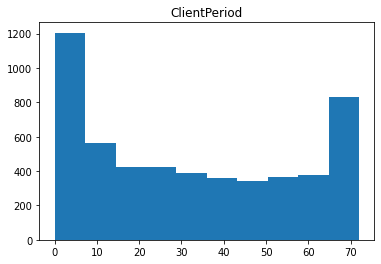

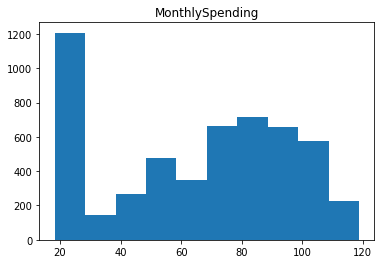

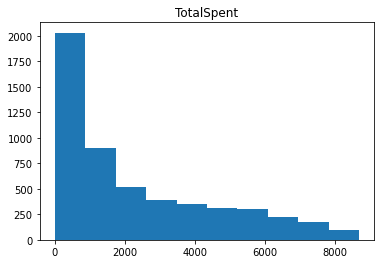

In [109]:
for col in num_cols:
  plt.hist(data[col])
  plt.title(col)
  plt.show()

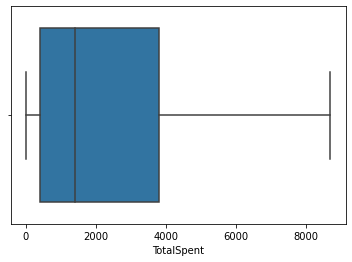

In [100]:
sns.boxplot(data['TotalSpent'])

наиболее важные фичи по мнению катбуст

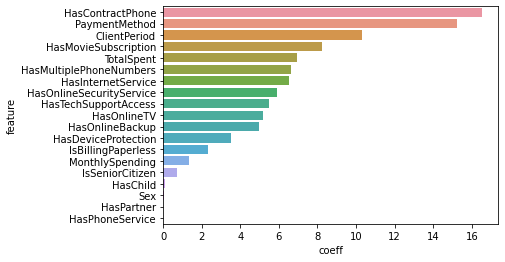

In [101]:
X, y = data[feature_cols], data[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
train_ds = Pool(data=X_train, label=y_train, cat_features=cat_cols, feature_names=feature_cols)
test_ds = Pool(data=X_test, label=y_test, cat_features=cat_cols, feature_names=feature_cols)
full_ds = Pool(data=X, label=y, cat_features=cat_cols, feature_names=feature_cols)
scale_pos_weight=(y_train==0).sum()/(y_train==1).sum()
cb = CatBoostClassifier(verbose=0, scale_pos_weight=scale_pos_weight,task_type="GPU", 
                        devices='0:1', random_seed=random_state).fit(train_ds)
df_feature_importances = pd.DataFrame(((zip(cb.feature_names_, cb.get_feature_importance())))).rename(columns={0:"feature",1:"coeff"}).sort_values(by="coeff", ascending = False )
sns.barplot(data=df_feature_importances, x=df_feature_importances["coeff"], y=df_feature_importances["feature"])

In [102]:
del X, y, X_train, X_test, y_train, y_test, train_ds, test_ds, full_ds

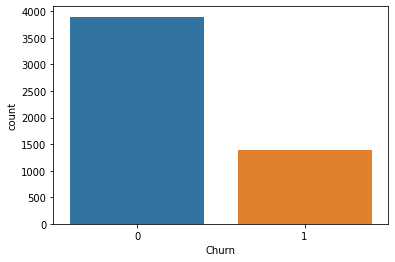

In [103]:
sns.countplot(data["Churn"])

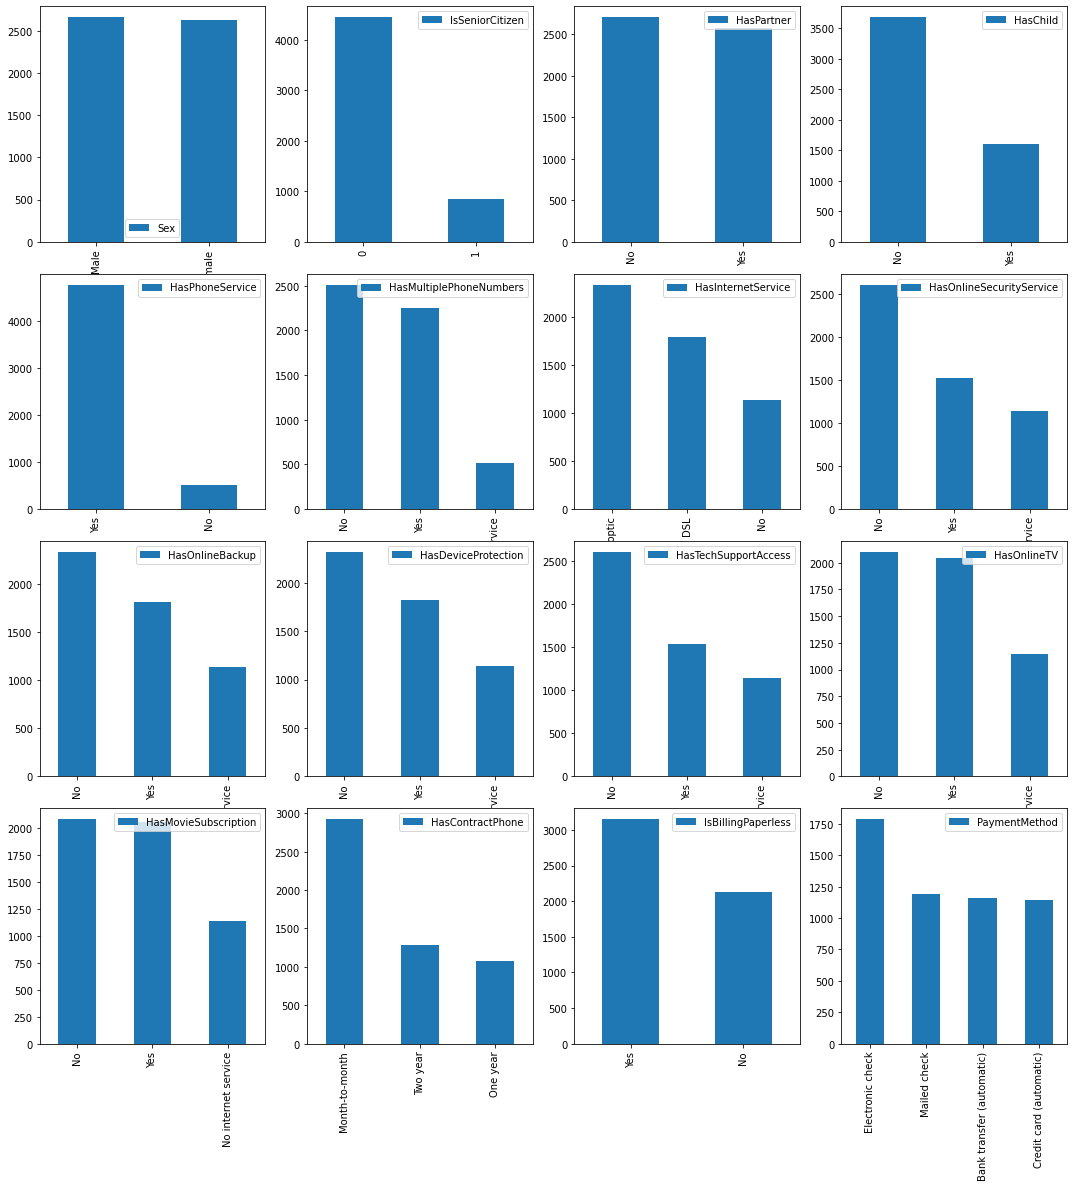

In [118]:
fig, axs = plt.subplots(4, len(cat_cols) // 4, figsize=(15,15))
axs = axs.flatten()
plt.tight_layout()
for cat_col, ax in zip(cat_cols, axs):
     data[cat_col].value_counts().plot(kind='bar', ax=ax)
     ax.legend()

plt.show()

In [104]:
display(data["Churn"].value_counts())
100*data["Churn"].value_counts()/len(data)

0    3898
1    1384
Name: Churn, dtype: int64

0    73.797804
1    26.202196
Name: Churn, dtype: float64

как видим классы несбалансированы, неплохо бы оверсэмплить(либо указывать веса катабусту)

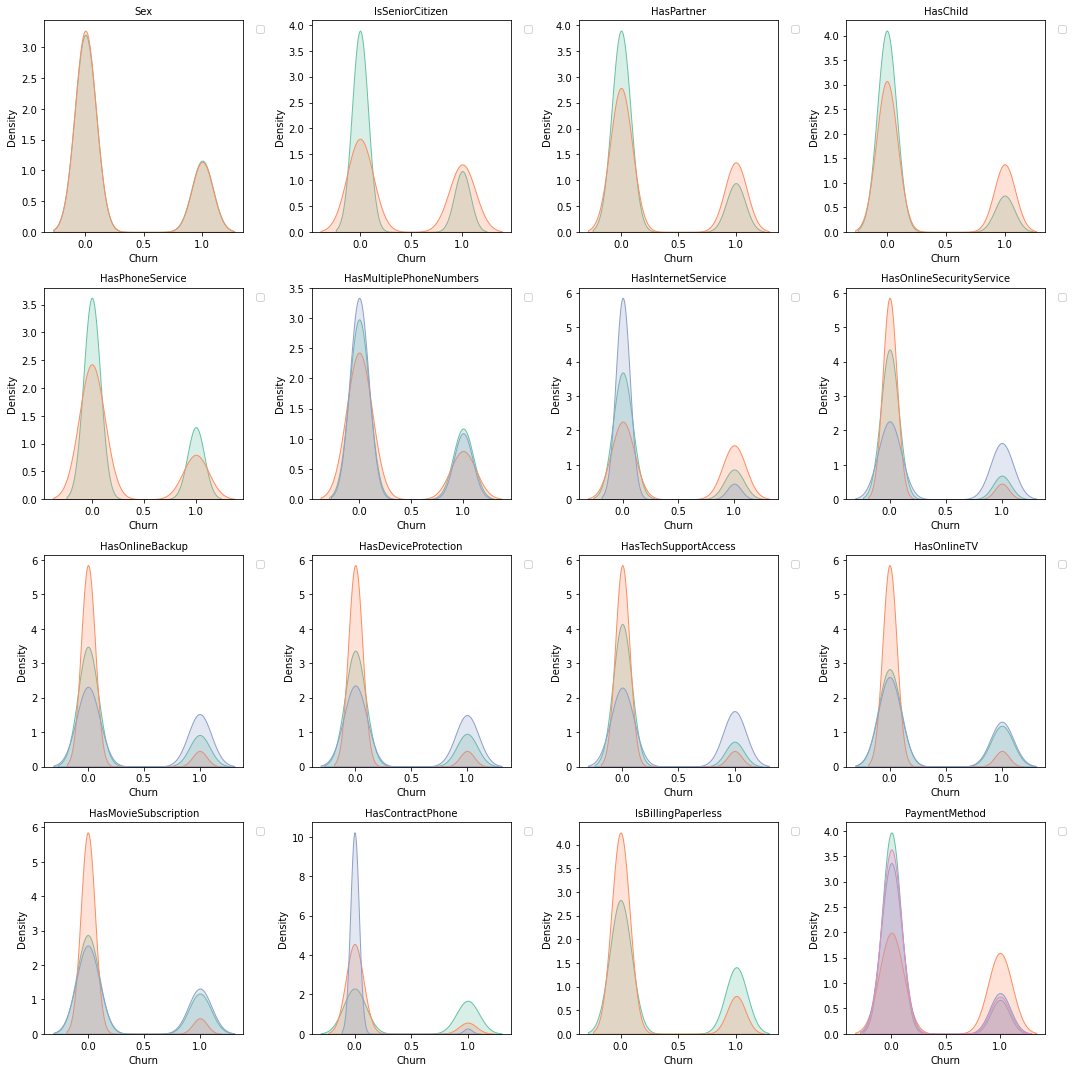

In [181]:
fig, axs = plt.subplots(4, len(cat_cols) // 4, figsize=(15,15))
axs = axs.flatten()

for cat_col, ax in zip(cat_cols, axs):
     display_group_density_plot(data, groupby = cat_col, on = target_col, \
                                           palette = sns.color_palette('Set2'), 
                                title=cat_col,
                           figsize = (10, 5), ax=ax)

plt.tight_layout()
plt.show()

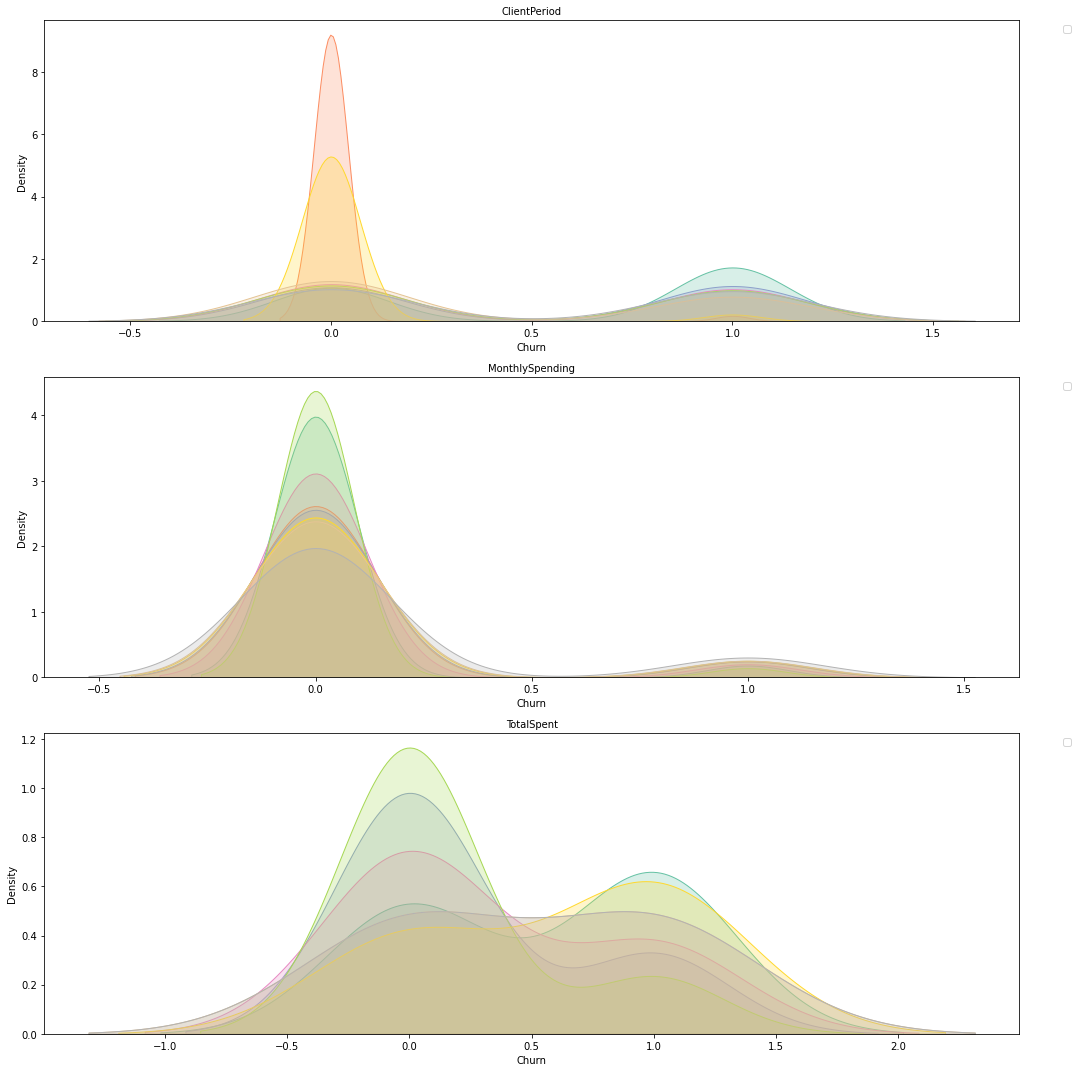

In [186]:
fig, axs = plt.subplots(3, len(num_cols) // 3, figsize=(15,15))
axs = axs.flatten()

for num_col, ax in zip(num_cols, axs):
     display_group_density_plot(data, groupby = num_col, on = target_col, \
                                           palette = sns.color_palette('Set2'), 
                                title=num_col,
                           figsize = (10, 5), ax=ax)

plt.tight_layout()
plt.show()

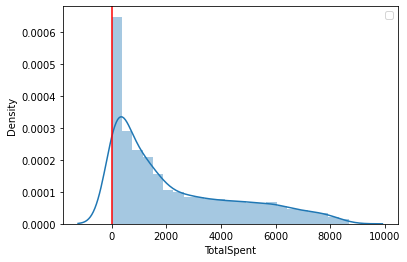

In [41]:
sns.distplot(data["TotalSpent"])
plt.axvline(0, c="r", label="")
plt.legend()

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

числовые данные плюс минус в порядке, TotalSpent можно отскалировать, категориальные не смотрел

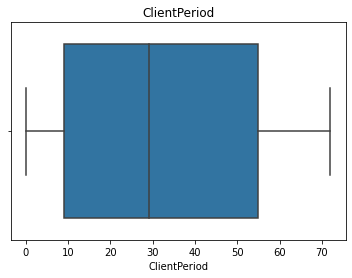

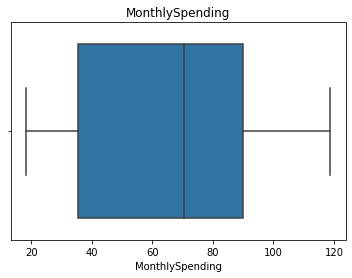

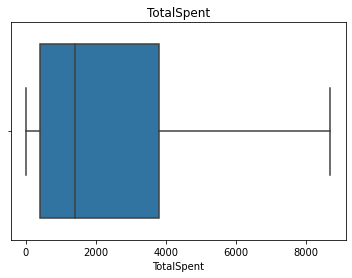

In [187]:
for col in num_cols:
  sns.boxplot(data[col])
  plt.title(col)
  plt.show()

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

для линейной модели можно бинарные категории просто в int перевести

In [188]:
df = data.copy()

In [189]:
for col in ["HasPartner",	"HasChild", "HasPhoneService", "IsBillingPaperless"]:
  df[col] = (df[col] == "Yes").astype("int")
df["Sex"] = (df["Sex"] == "Male").astype("int")

In [192]:
df = pd.get_dummies(df, drop_first=True)

In [197]:
features = set(df.columns) - set([target_col])
X, y = df[features].values, df[target_col].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
lr = LogisticRegressionCV(cv=5, random_state=42).fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [198]:
display_classification_report(y_test, y_pred)

,precision,recall,f1-score,support
0,0.813397,0.885417,0.847880,384.000000
1,0.603604,0.462069,0.523438,145.000000
accuracy,0.769376,0.769376,0.769376,0.769376
macro avg,0.708500,0.673743,0.685659,529.000000
weighted avg,0.755892,0.769376,0.758950,529.000000


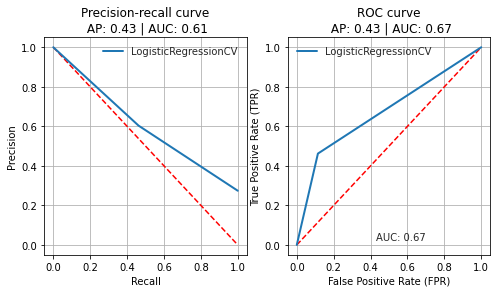

In [199]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax = ax.flatten()
plot_pr(y_test, y_pred, ax=ax[0],label="LogisticRegressionCV")
plot_roc(y_test, y_pred, ax=ax[1],label="LogisticRegressionCV")

In [200]:
roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])

0.8086566091954024

0.782608695652174
[[343  41]
 [ 74  71]]


,precision,recall,f1-score,support
0,0.822542,0.893229,0.856429,384.000000
1,0.633929,0.489655,0.552529,145.000000
accuracy,0.782609,0.782609,0.782609,0.782609
macro avg,0.728235,0.691442,0.704479,529.000000
weighted avg,0.770843,0.782609,0.773130,529.000000


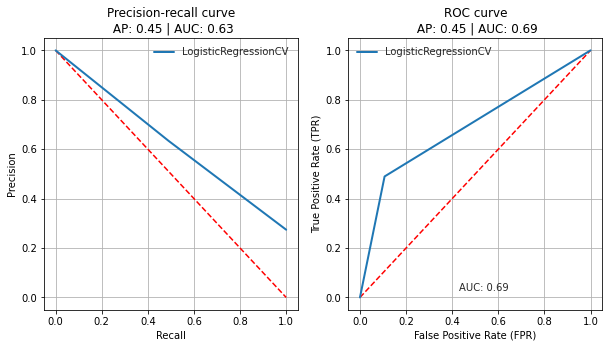

In [201]:
lrcv = LogisticRegressionCV(
    Cs=[0.1,1,10], penalty='l2', tol=1e-10, scoring='neg_log_loss', cv=5,
    solver='liblinear', n_jobs=4, verbose=0, refit=True,
    max_iter=100,
).fit(X_train, y_train)
y_pred = lrcv.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
display_classification_report(y_test, y_pred)

_, axs = plt.subplots(1, 2,figsize=(10,5))
axs = axs.ravel()
plot_pr(y_test, y_pred, ax=axs[0], label="LogisticRegressionCV")
plot_roc(y_test, y_pred, ax=axs[1], label="LogisticRegressionCV")

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

In [202]:
params = {
"criterion":["gini", "entropy"],
"max_depth":[2,4,8,16],
"min_samples_split":[2,4,8, 16],
"min_samples_leaf":[2,4,6]}
clf = GridSearchCV(DecisionTreeClassifier(), params, cv=5).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(clf.score(X_train, y_train))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
display_classification_report(y_test, y_pred)

0.7929728592467915
0.780718336483932
[[362  22]
 [ 94  51]]


,precision,recall,f1-score,support
0,0.793860,0.942708,0.861905,384.000000
1,0.698630,0.351724,0.467890,145.000000
accuracy,0.780718,0.780718,0.780718,0.780718
macro avg,0.746245,0.647216,0.664897,529.000000
weighted avg,0.767757,0.780718,0.753904,529.000000


In [204]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

0.8029274425287356

0.7929728592467915
0.780718336483932
[[362  22]
 [ 94  51]]


,precision,recall,f1-score,support
0,0.793860,0.942708,0.861905,384.000000
1,0.698630,0.351724,0.467890,145.000000
accuracy,0.780718,0.780718,0.780718,0.780718
macro avg,0.746245,0.647216,0.664897,529.000000
weighted avg,0.767757,0.780718,0.753904,529.000000


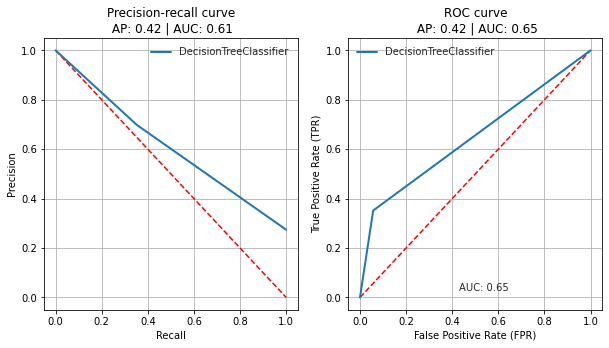

In [206]:
dt = DecisionTreeClassifier(**clf.best_params_).fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(dt.score(X_train, y_train))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
display_classification_report(y_test, y_pred)

_, axs = plt.subplots(1, 2,figsize=(10,5))
axs = axs.ravel()
plot_pr(y_test, y_pred, ax=axs[0], label="DecisionTreeClassifier")
plot_roc(y_test, y_pred, ax=axs[1], label="DecisionTreeClassifier")

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [269]:
X, y = data[feature_cols], data[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
train_ds = Pool(data=X_train, label=y_train, cat_features=cat_cols, feature_names=feature_cols)
test_ds = Pool(data=X_test, label=y_test, cat_features=cat_cols, feature_names=feature_cols)
full_ds = Pool(data=X, label=y, cat_features=cat_cols, feature_names=feature_cols)

In [208]:
scale_pos_weight=(y_train==0).sum()/(y_train==1).sum()

In [209]:
cb = CatBoostClassifier(verbose=0, scale_pos_weight=scale_pos_weight,task_type="GPU", 
                        devices='0:1', random_seed=random_state).fit(train_ds)


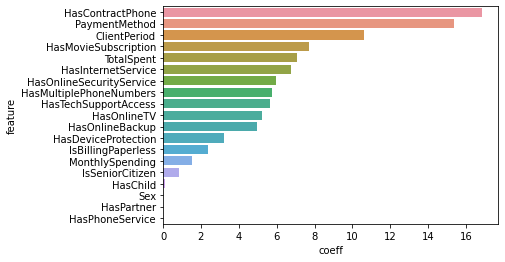

In [55]:
df_feature_importances = pd.DataFrame(((zip(cb.feature_names_, cb.get_feature_importance())))).rename(columns={0:"feature",1:"coeff"}).sort_values(by="coeff", ascending = False )
sns.barplot(data=df_feature_importances, x=df_feature_importances["coeff"], y=df_feature_importances["feature"])

In [210]:
y_pred = cb.predict(test_ds)
print(cb.score(train_ds))

0.7708815484956869


0.7429111531190926
[[282 102]
 [ 34 111]]


,precision,recall,f1-score,support
0,0.892405,0.734375,0.805714,384.000000
1,0.521127,0.765517,0.620112,145.000000
accuracy,0.742911,0.742911,0.742911,0.742911
macro avg,0.706766,0.749946,0.712913,529.000000
weighted avg,0.790637,0.742911,0.754840,529.000000


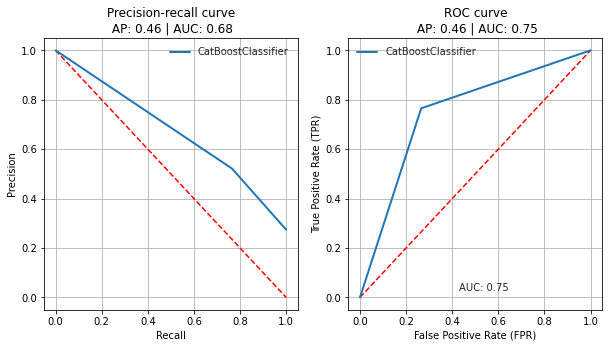

In [211]:
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
display_classification_report(y_test, y_pred)

_, axs = plt.subplots(1, 2,figsize=(10,5))
axs = axs.ravel()
plot_pr(y_test, y_pred, ax=axs[0], label="CatBoostClassifier")
plot_roc(y_test, y_pred, ax=axs[1], label="CatBoostClassifier")

In [217]:
param_grid = {
        'learning_rate': [0.03, 0.1],
        'depth': [6, 10, 20, 40],
        'l2_leaf_reg': [3, 5, 7, 9],
        'iterations':[20, 60],
        'thread_count':[12],
        'border_count':[128]
}

model = CatBoostClassifier(loss_function='Logloss',eval_metric='AUC', task_type="GPU", devices='0:1', random_seed=random_state)
grid_search_result = model.grid_search(param_grid, 
                                       full_ds,
                                       verbose=0,
                                       partition_random_seed=random_state,
                                       search_by_train_test_split=True,
                                       train_size=0.9,
                                       plot=False)

bestTest = 0.7944921255
bestIteration = 19
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
bestTest = 0.8270556629
bestIteration = 19
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
bestTest = 0.7954910398
bestIteration = 16
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
bestTest = 0.8262721896
bestIteration = 19
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
bestTest = 0.7936498523
bestIteration = 18
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
bestTest = 0.8254299462
bestIteration = 19
Metric AUC is not calculated on train by default. To calculate this metr

In [220]:
cv_data = pd.DataFrame(grid_search_result["cv_results"])
best_value = cv_data['test-AUC-mean'].max()
best_iter = cv_data['test-AUC-mean'].values.argmax()

print('Best validation test-AUC-mean : {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-AUC-std'][best_iter],
    best_iter)
)

Best validation test-AUC-mean : 0.8450±0.0050 on step 58


In [227]:
model = CatBoostClassifier(loss_function='Logloss', task_type="GPU", devices='0:1', random_seed=random_state, **grid_search_result["params"])
model.fit(train_ds, verbose = 0, eval_set = [(X_test, y_test)], use_best_model=True)
y_pred = model.predict(test_ds)
print("accuracy_score", accuracy_score(y_test, y_pred))
for i in [10, 15, 20]:
  print("roc_auc_score", roc_auc_score(y_test, model.predict_proba(test_ds, ntree_start=0, ntree_end=i)[:,1]))
print("f1_score", f1_score(y_test, y_pred))

accuracy_score 0.7844990548204159
roc_auc_score 0.8031519396551724
roc_auc_score 0.8083692528735633
roc_auc_score 0.8110452586206897
f1_score 0.5210084033613445


In [230]:
class paramsearch:
    def __init__(self,pdict):    
        self.pdict = {}
        # if something is not passed in as a sequence, make it a sequence with 1 element
        #   don't treat strings as sequences
        for a,b in pdict.items():
            if isinstance(b, collections.Sequence) and not isinstance(b, str): self.pdict[a] = b
            else: self.pdict[a] = [b]
        # our results are a sorted list, so the best score is always the final element
        self.results = SortedList()       
                    
    def grid_search(self,keys=None):
        # do grid search on only the keys listed. If none provided, do all
        if keys==None: keylist = self.pdict.keys()
        else: keylist = keys
 
        listoflists = [] # this will be list of lists of key,value pairs
        for key in keylist: listoflists.append([(key,i) for i in self.pdict[key]])
        for p in product(*listoflists):
            # do any changes to the current best parameter set
            if len(self.results)>0: template = self.results[-1][1]
            else: template = {a:b[0] for a,b in self.pdict.items()}
            # if our updates are the same as current best, don't bother
            if self.equaldict(dict(p),template): continue
            # take the current best and update just the ones to change
            yield self.overwritedict(dict(p),template)
                              
    def equaldict(self,a,b):
        for key in a.keys(): 
            if a[key] != b[key]: return False
        return True            
                              
    def overwritedict(self,new,old):
        old = copy.deepcopy(old)
        for key in new.keys(): old[key] = new[key]
        return old            
    
    # save a (score,params) pair to results. Since 'results' is a sorted list,
    #   the best score is always the final element. A small amount of noise is added
    #   because sorted lists don't like it when two scores are exactly the same    
    def register_result(self,result,params):
        self.results.add((result+np.random.randn()*1e-10,params))    
        
    def bestscore(self):
        return self.results[-1][0]
        
    def bestparam(self):
        return self.results[-1][1]
        


In [ ]:
import pandas
import numpy as np
import catboost as cb
from sklearn.model_selection import KFold
from itertools import product,chain

train_set = X_train
test_set = X_test

# X, y = data[feature_cols], data[target_col]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
# full_ds = Pool(data=X, label=y, cat_features=cat_cols, feature_names=feature_cols)

colnames = feature_cols
category_cols = cat_cols
cat_dims = [train_set.columns.get_loc(i) for i in category_cols[:-1]] 
# for header in category_cols:
#     train_set[header] = train_set[header].astype('category').cat.codes
#     test_set[header] = test_set[header].astype('category').cat.codes

# split labels out of data sets    
train_label = y_train.values
test_label = y_test.values

params = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,20,50,100,200],
          'thread_count':4}

# this function does 3-fold crossvalidation with catboostclassifier          
def crossvaltest(params,train_set,train_label,cat_dims,n_splits=3):
    kf = KFold(n_splits=n_splits,shuffle=True) 
    res = []
    for train_index, test_index in kf.split(train_set):
        train = train_set.iloc[train_index,:]
        test = train_set.iloc[test_index,:]
        
        labels = train_label[train_index]
        test_labels = train_label[test_index]

        train_ds = Pool(data=train, label=labels, cat_features=cat_cols, feature_names=feature_cols)
        test_ds = Pool(data=test, label=test_labels, cat_features=cat_cols, feature_names=feature_cols)

        scale_pos_weight=(labels==0).sum()/(labels==1).sum()
        clf = CatBoostClassifier(**params, verbose=0, scale_pos_weight=scale_pos_weight)
        clf.fit(train_ds)
        res.append(np.mean(roc_auc_score(test_labels, clf.predict_proba(test_ds)[:,1])))
        # res.append(np.mean(clf.predict(test)==np.ravel(test_labels)))
    return np.mean(res)
  
# this function runs grid search on several parameters
def catboost_param_tune(params,train_set,train_label,cat_dims=None,n_splits=3):
    ps = paramsearch(params)
    # search 'border_count', 'l2_leaf_reg' etc. individually 
    #   but 'iterations','learning_rate' together
    max_metric = 0
    best_param = {}
    for prms in chain(ps.grid_search(['border_count']),
                      ps.grid_search(['l2_leaf_reg']),
                      ps.grid_search(['iterations','learning_rate']),
                      ps.grid_search(['depth'])):
        res = crossvaltest(prms,train_set,train_label,cat_dims,n_splits)
        # save the crossvalidation result so that future iterations can reuse the best parameters
        ps.register_result(res,prms)
        if max_metric<res: 
          max_metric = res
          best_param = prms
        print(res,prms,'best:',ps.bestscore(),ps.bestparam())
    # return ps.bestparam()
    return best_param

bestparams = catboost_param_tune(params,train_set,train_label,cat_dims)

0.8462884500695721 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 5, 'thread_count': 4} best: 0.8462884501950009 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 5, 'thread_count': 4}
0.8479155510054192 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 10, 'thread_count': 4} best: 0.8479155510207382 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 10, 'thread_count': 4}
0.8475058351568672 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 20, 'thread_count': 4} best: 0.8479155510207382 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 10, 'thread_count': 4}
0.8505465595392367 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 50, 'thread_count': 4} best: 0.8505465596012183 {'depth': 3, 'iterations': 250, 'learning_

In [279]:
X, y = data[feature_cols], data[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
train_ds = Pool(data=X_train, label=y_train, cat_features=cat_cols, feature_names=feature_cols)
test_ds = Pool(data=X_test, label=y_test, cat_features=cat_cols, feature_names=feature_cols)
full_ds = Pool(data=X, label=y, cat_features=cat_cols, feature_names=feature_cols)

clf = CatBoostClassifier(**bestparams, verbose=0)
clf.fit(train_ds)
roc_auc_score(y_test, clf.predict_proba(test_ds)[:,1])

0.8241379310344827

In [257]:
bestparams = {'depth': 4, 'iterations': 500, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 10, 'thread_count': 4}
clf = CatBoostClassifier(**bestparams, verbose=0)
clf.fit(train_set, np.ravel(train_label), cat_features=cat_dims)
roc_auc_score(test_label, clf.predict_proba(test_set)[:,1])

0.8239403735632183

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

# Предсказания

In [289]:
best_model = clf

In [291]:
X_test = pd.read_csv('https://drive.google.com/uc?id=1JmoeWw0Y3M7q5DunTVmWioMgXDXBt02r')
test_ds = Pool(data=X_test.values, cat_features=cat_cols, feature_names=feature_cols)

In [297]:
submission = pd.read_csv('https://drive.google.com/uc?id=15lHpRREzDVihgDZ866CXueuibKEgPRJg')

submission['Churn'] = clf.predict_proba(test_ds)[:,1] # best_model.predict_proba(X_test) / best_model.predict(X_test)
submission.to_csv('./my_submission.csv', index=False)

In [298]:
##colab
try:
  from google.colab import files
  files.download('my_submission.csv')
except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

результат 0.85094 ,что достаточно (поскольку больше 84;))
не нашел где взять номер посылки, скрин ниже

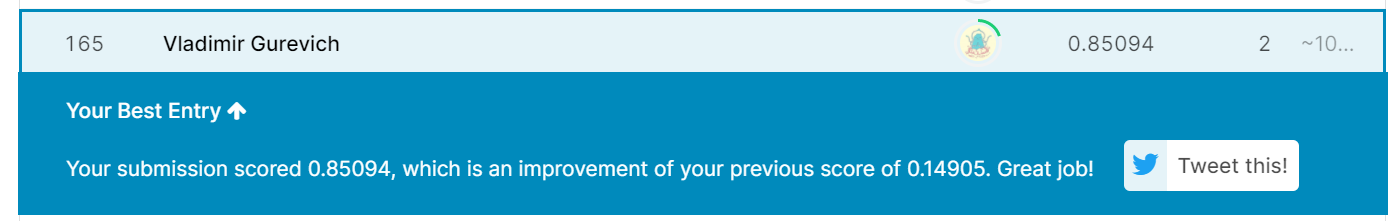

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.